# Qube-calib Tutorial

QubeCalib は Qube を使った量子実験を支援するための Python パッケージである．Qube の信号の入出力に注目してハードウェアの設定を容易にするためのモジュールと，バルス制御を容易にするモジュールにより構成される．e7awgsw と qubelsi の機能を利用しています． Qube 固有の機能を操作するために，e7awgsw や qubelsi を直接触れるように配慮しています．

# Qube-calib による Qube の制御

## Qube オブジェクトの生成

qube-calib では Qube 装置へのアクセスを qubecalib.qube.Qube オブジェクトを介して行います．装置の再起動やリセットを簡単に操作するための gui を提供する qubecalib.ui.QubeControl オブジェクトを用いても Qube オブジェクトを取得できます．qubecalib.ui.QubeControl の各機能は qubecalib.boottools に関数として（これから）まとめるので，それらの関数を実行することでバッチ実行することもでき（るようになり）ます．

### 電源投入時の操作
- `[Boot Unit]` ボタンを押し Qube ユニットの AU50 を再起動し LSI 類を初期化する．

<!--
- `[do_init]` ボタンは Qube ユニットの LSI 類を再起動します．AU50 は再起動しません．通常は実行しないでください．
- `[Kick soft reset]` ボタンはうまく動きません．実行しないでください．（そのうち隠します．）
-->

### `LinkStatus` の `0x55E` が `0xE0` 以外の値を示しているとき，
次の優先順位で操作してください．
1. `[Reatart AD9082]` ボタンを押しデータコンバータのみを再起動する．
1. `[do_init]` ボタンを押し各種 LSI 類を初期化する．
1. `[Boot Unit]` ボタンを押し Qube ユニットの AU50 を再起動し LSI 類を初期化する．

### `awg timeout` や `capture unit timeout` などのエラーが直らない場合の復帰操作
AU50 の再起動が必要です．
1. `[Boot Unit]` ボタンを押し Qube ユニットの AU50 を再起動し LSI 類を初期化する．

### qubecalib.ui.QubeControl による Qube オブジェクトの生成例


In [12]:
import qubecalib as qc
# ---- このタイミングでインポートすること ----
%matplotlib inline
import matplotlib.pyplot as plt
# --------------------------------------
qc.ui.MATPLOTLIB_PYPLOT = plt
qube = qube1 = qc.ui.QubeControl('qube_riken_1-02.yml').qube

## LSI の設定方法
    周波数
    出力
    経路スイッチ

In [2]:
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

65535

# `backendqube` モジュールによるパルスの出力・受信

`backendqube` モジュールは Qube の任意波形生成器を制御する e7awgsw の機能のうち，バルスの出力・検出を支援するものです．様々な動作モード毎の処理を内蔵し，統一的な方法でパルスの出力・検出を行うことができます．

## 基本的な使い方

バルスを出力するには，`((qube.port0.awg0, WaveSequence), (qube.port1.capt.unit0, CaptureParam), ...)` のように波形を出力したい `qubecalib.qube.AWG` と `WaveSequence` を組にしたタプル（リストでもよし）， と `qubecalib.qube.UNIT` と `CaptureParam` を組にしたタプルを要素とする `list` や `tuple` を引数（例えば `setup`）として `r = qubecalib.backendqube.send_recv(*setup)` のように与えます．戻り値 `r` は `qubecalib.qube.UNIT` をキーとする辞書として受信結果が返されます．受信結果は `List[Array[complex, ...], ...]` の形で返される．e7awgsw の DSP の設定によって各要素の様子は変化するが，DSP を全て無効にしたときには，`List` の要素番号は総和区間番号と等しく，`Array` の `axis=1` が各積算区間番号， `axis=0` がサンプル番号を示す．以下に基本的なコードを示します．

- https://github.com/e-trees/e7awg_sw/tree/main/manuals
- https://github.com/e-trees/e7awg_sw/blob/main/e7awgsw/wavesequence.py
- https://github.com/e-trees/e7awg_sw/blob/main/e7awgsw/captureparam.py

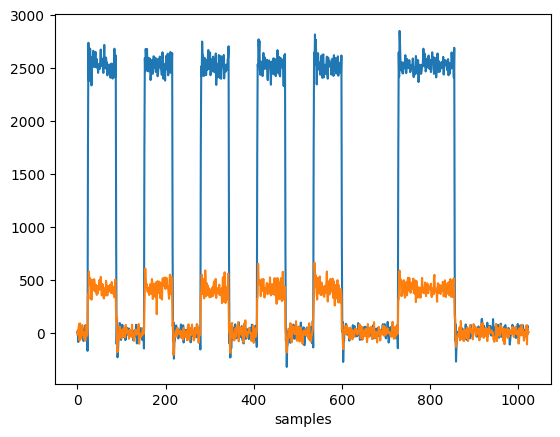

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qubecalib as qc
import qubecalib.backendqube as backend
import e7awgsw

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = e7awgsw.WaveSequence(num_wait_words=16,num_repeats=1) # 1 word = 4 samples = 8 ns
w.add_chunk(iq_samples=16*4*[(int(0.05*32767),0),],num_blank_words=16,num_repeats=4)
w.add_chunk(iq_samples=16*4*[(int(0.05*32767),0),],num_blank_words=32,num_repeats=1)
w.add_chunk(iq_samples=32*4*[(int(0.05*32767),0),],num_blank_words=16,num_repeats=1)

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=256, num_post_blank_words=1)
p.capture_delay = 8*16 # [0:15][16:31][32:47]...

setup = ((qube.port0.awg0, w), (qube.port1.capt.unit0, p))

r = backend.send_recv(*setup)

fig = plt.figure()
ax = fig.gca()
ax.plot(np.real(r[qube.port1.capt.unit0][0]))
ax.plot(np.imag(r[qube.port1.capt.unit0][0]))
fig.axes[-1].set_xlabel('samples')
plt.show()


## WaveSequenceFactory の利用

WaveSequence の iq データを複素数型の numpy アレイで操作できるようにしたラッパーです．

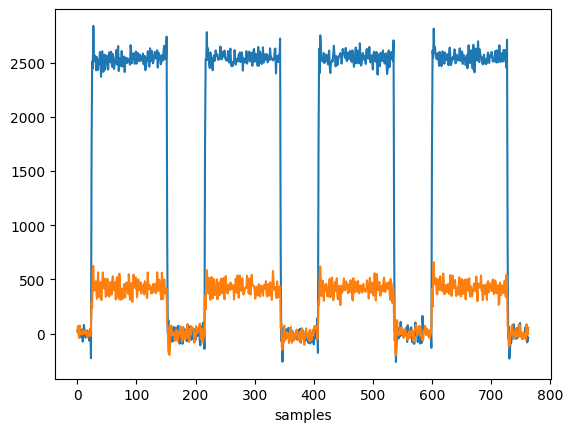

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import qubecalib as qc
import qubecalib.backendqube as backend
import e7awgsw

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.gpio.write_value(0xFFFF) # Loopback

w = backend.WaveSequenceFactory(num_wait_words=0,num_repeats=1) # 1 word = 4 samples = 8 ns
w.new_chunk(backend.WaveChunkFactory(num_wave_words=2*16, num_blank_words=16, num_repeats=4, init=0, amp=32767))
w.chunk[-1].iq[:] = 0.05

p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.add_sum_section(num_words=4*(3*16)-1, num_post_blank_words=1)
p.capture_delay = 7*16 # [0:15][16:31][32:47]...

setup = ((qube.port0.awg0, w.acquire()), (qube.port1.capt.unit0, p))

r = backend.send_recv(*setup)

fig = plt.figure()
ax = fig.gca()
ax.plot(np.real(r[qube.port1.capt.unit0][0]))
ax.plot(np.imag(r[qube.port1.capt.unit0][0]))
fig.axes[-1].set_xlabel('samples')
plt.show()


# `neopulse` モジュールによるパルスの出力・受信

`neopulse` モジュールは論理チャネル－時間で構成される空間に所望のパルスを配置するための簡易言語です．Python の標準機能を少し拡張する形で実装されています．`backendqube` モジュールを用いた場合よりも複雑なバルスを取り扱いたい場合には `neopulse` モジュールを用いるのが適しています．特に，周波数多重を用いる場合は `neopulse` モジュールを用いた方が楽に設定できます．将来 Qube がアップデートされた際にもパルスシーケンスの資源を活用できる程度には抽象化されています．Qube 固有の機能や新機能をスムーズに試せるよう，`backendqube.send_recv()` 関数へ渡す引数を自動生成するように作られています．DSP の設定などは `backendqube` モジュールを用いた場合と同様の仕組みが使えます．

パルススロットオブジェクトは slot.begin, slot.end, slot.duration プロパティを備えています．duration はパルスの継続時間を示していて独立変数です．begin と end はスロットの開始端，終了端を示していて，互いにいずれかが決まるともう一方が決まる従属変数です．

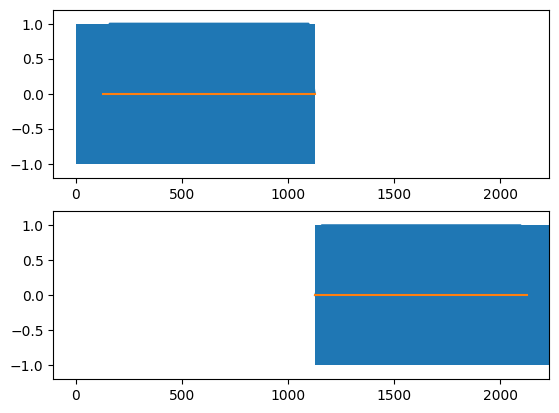

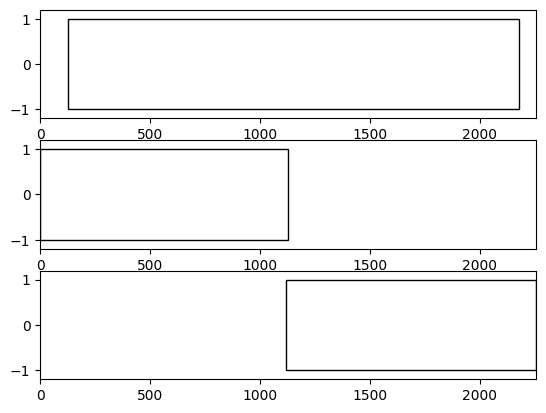

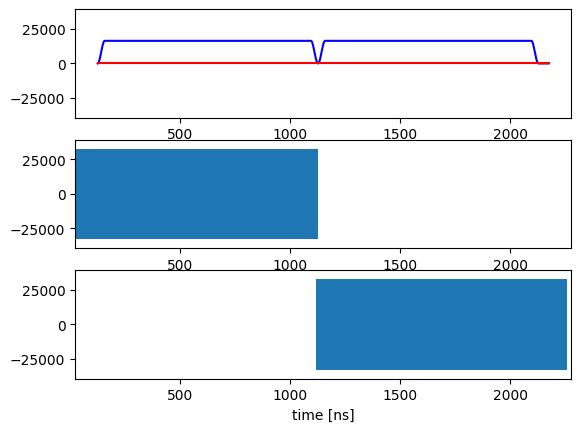

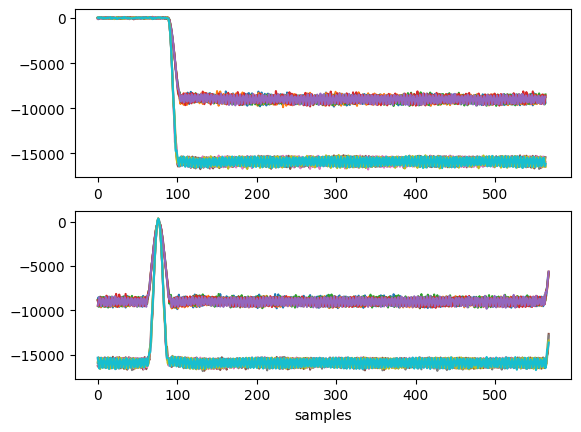

In [4]:
# =============================
# 共通部分
# =============================

%matplotlib inline
import matplotlib.pyplot as plt

from typing import Final

import e7awgsw
import qubecalib as qc
import qubecalib.neopulse as pulse
import qubecalib.backendqube as backend
from qubecalib.backendqube import ChannelMap
from qubecalib.neopulse import Sequence
from qubecalib.neopulse import RaisedCosFlatTop, Capture, Blank
from qubecalib.neopulse import Series, Flushleft, Flushright
from qubecalib.neopulse import Control, Readout
from qubecalib.units import *

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400
qube.port7.lo.mhz = 12000
qube.port7.nco.mhz = 2000
qube.port7.mix.vatt = 0x400
qube.port8.lo.mhz = 12000
qube.port8.nco.mhz = 2000
qube.port8.mix.vatt = 0x400
qube.port12.nco.mhz = 2000
qube.port13.lo.mhz = 8000
qube.port13.nco.mhz = 2000
qube.port13.mix.vatt = 0x400
qube.gpio.write_value(0xFFFF) # Loopback

# define Physical Port
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6
TXQ3: Final[qc.qube.Port] = qube.port7
TXQ4: Final[qc.qube.Port] = qube.port8
MUX2RX: Final[qc.qube.Port] = qube.port12
MUX2TX: Final[qc.qube.Port] = qube.port13

# define Logical Channel
RQ1: Final[Readout] = Readout(10000*MHz)
RQ2: Final[Readout] = Readout(10000*MHz)
CQ1: Final[Control] = Control(9990*MHz)
CQ2: Final[Control] = Control(10100*MHz)
CQ3: Final[Control] = Control(10100*MHz)
CQ4: Final[Control] = Control(9990*MHz)
RQ3: Final[Readout] = Readout(10000*MHz)
RQ4: Final[Readout] = Readout(10000*MHz)


with ChannelMap() as m:
    m.map(MUX1TX.awg0, RQ1, RQ2)
    m.map(MUX1RX.capt.unit0, RQ1)
    m.map(MUX1RX.capt.unit1, RQ2)
    m.map(TXQ1.awg0, CQ1)
    m.map(TXQ2.awg0, CQ2)
    m.map(TXQ3.awg0, CQ3)
    m.map(TXQ4.awg0, CQ4)
    m.map(MUX2RX.capt.unit0, RQ3)
    m.map(MUX2RX.capt.unit1, RQ4)
    m.map(MUX2TX.awg0, RQ3, RQ4)
channel_map = m

# =============================
# 共通部分：ここまで
# =============================

with Sequence() as sequence:

    RaisedCosFlatTop(duration=1000*nS, end=1128*nS, rise_time=32*nS).set_channel(RQ1)
    Capture(duration=1128*nS, end=1128*nS).set_channel(RQ1)
    RaisedCosFlatTop(begin=1128*nS, duration=1000*nS, rise_time=32*nS).set_channel(RQ2)
    Capture(begin=1128*nS, duration=1128*nS).set_channel(RQ2)
    
fig = plt.figure()
pulse.plot_sequence(fig, sequence.flatten())
plt.show()

section = backend.acquire_section(sequence, channel_map)

fig = plt.figure()
backend.plot_section(fig, section)
plt.show()

period = backend.quantize_sequence_duration(sequence_duration=400*uS)
setup = backend.convert(sequence.flatten(), section, channel_map, period, 5)

capture_delay = d = 7 * 16 # [words] int(7*2*WORDs)
for p, u, o in setup.captparams(channel_map):
    backend.captparam_add_capture_delay(p, d)
    # backend.captparam_enable_demodulation(p, u, o)
    # backend.captparam_enable_integration(p)

fig = plt.figure()
backend.plot_setup(fig,setup,capture_delay=d)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

r = backend.send_recv(*setup)

fig = plt.figure()
backend.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('samples')
plt.show()


### `neopulse` の動作

`with Sequence` ブロックが開かれると，`neopulse.__rc__.context` に `deque` （軽量のリストのようなもの）が追加されます．`Slot` は `context[-1]` の一番最近作られたコンテキストキューに自分自身を追加してゆきます．`Sequence` ブロックが閉じられるときにコンテキストキューの内容が `Sequence` に転記され `as` 以下の変数が `Sequence` オブジェクトをポイントします．

# 周波数多重

Qube を利用した周波数多重のコード例を示します．

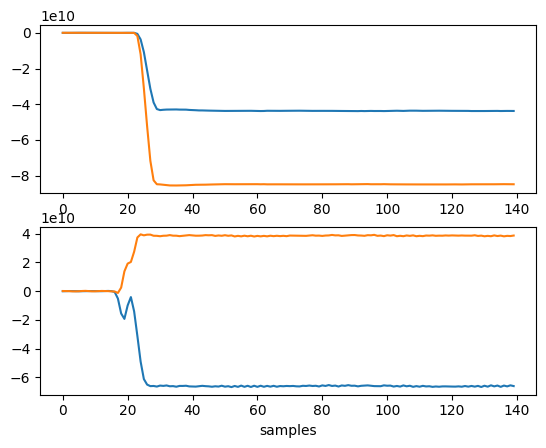

In [17]:
# =============================
# 共通部分
# =============================

%matplotlib inline
import matplotlib.pyplot as plt

from typing import Final

import e7awgsw
import qubecalib as qc
import qubecalib.neopulse as pulse
import qubecalib.backendqube as backend
from qubecalib.backendqube import ChannelMap
from qubecalib.neopulse import Sequence
from qubecalib.neopulse import RaisedCosFlatTop, Capture, Blank
from qubecalib.neopulse import Series, Flushleft, Flushright
from qubecalib.neopulse import Control, Readout
from qubecalib.units import *

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400
qube.port7.lo.mhz = 12000
qube.port7.nco.mhz = 2000
qube.port7.mix.vatt = 0x400
qube.port8.lo.mhz = 12000
qube.port8.nco.mhz = 2000
qube.port8.mix.vatt = 0x400
qube.port12.nco.mhz = 2000
qube.port13.lo.mhz = 8000
qube.port13.nco.mhz = 2000
qube.port13.mix.vatt = 0x400
qube.gpio.write_value(0xFFFF) # Loopback

# define Physical Port
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6
TXQ3: Final[qc.qube.Port] = qube.port7
TXQ4: Final[qc.qube.Port] = qube.port8
MUX2RX: Final[qc.qube.Port] = qube.port12
MUX2TX: Final[qc.qube.Port] = qube.port13

# define Logical Channel
RQ1: Final[Readout] = Readout(10000*MHz)
RQ2: Final[Readout] = Readout(10020*MHz)
CQ1: Final[Control] = Control(9990*MHz)
CQ2: Final[Control] = Control(10100*MHz)
CQ3: Final[Control] = Control(10100*MHz)
CQ4: Final[Control] = Control(9990*MHz)
RQ3: Final[Readout] = Readout(10000*MHz)
RQ4: Final[Readout] = Readout(10000*MHz)


with ChannelMap() as m:
    m.map(MUX1TX.awg0, RQ1, RQ2)
    m.map(MUX1RX.capt.unit0, RQ1)
    m.map(MUX1RX.capt.unit1, RQ2)
    m.map(TXQ1.awg0, CQ1)
    m.map(TXQ2.awg0, CQ2)
    m.map(TXQ3.awg0, CQ3)
    m.map(TXQ4.awg0, CQ4)
    m.map(MUX2RX.capt.unit0, RQ3)
    m.map(MUX2RX.capt.unit1, RQ4)
    m.map(MUX2TX.awg0, RQ3, RQ4)
channel_map = m

# =============================
# 共通部分：ここまで
# =============================

with Sequence() as sequence:

    RaisedCosFlatTop(duration=1000*nS, end=1128*nS, rise_time=32*nS).set_channel(RQ1)
    Capture(duration=1128*nS, end=1128*nS).set_channel(RQ1)
    RaisedCosFlatTop(begin=1128*nS, duration=1000*nS, rise_time=32*nS).set_channel(RQ2)
    Capture(begin=1128*nS, duration=1128*nS).set_channel(RQ2)
    
# fig = plt.figure()
# pulse.plot_sequence(fig, sequence.flatten())
# plt.show()

section = backend.acquire_section(sequence, channel_map)

# fig = plt.figure()
# pulse.plot_section(fig, section)
# plt.show()

period = backend.quantize_sequence_duration(sequence_duration=400*uS)
setup = backend.convert(sequence.flatten(), section, channel_map, period, 5)

capture_delay = d = 7 * 16 # [words] int(7*2*WORDs)
for p, u, o in setup.captparams(channel_map):
    backend.captparam_add_capture_delay(p, d)
    backend.captparam_enable_demodulation(p, u, o)
    backend.captparam_enable_integration(p)

# fig = plt.figure()
# pulse.plot_setup(fig,setup,capture_delay=d)
# fig.axes[-1].set_xlabel('time [ns]')
# plt.show()

r = backend.send_recv(*setup)

fig = plt.figure()
backend.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('samples')
plt.show()


## エッジリンク

量子実験をする際にパルスのエッジを揃えたい場合がしばしばあります．このような場合に使うのがエッジリンクです．パルススロットオブジェクトの begin, end, duration のプロパティのうち begin と end は相互にリンクして値を同期することができます．この性質を利用してパルスのエッジを簡単に揃えることができます．実験サイクル中に duration の値をスイープしてパルスの配置を自動調整することができます．

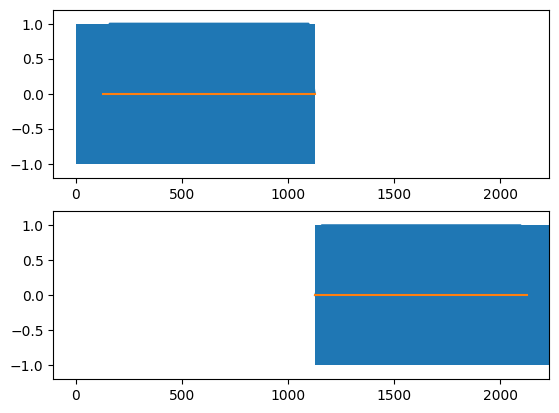

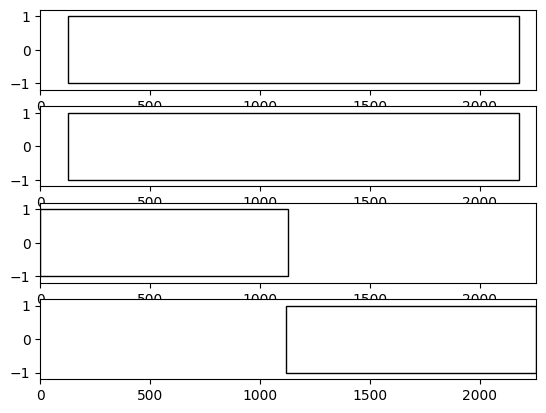

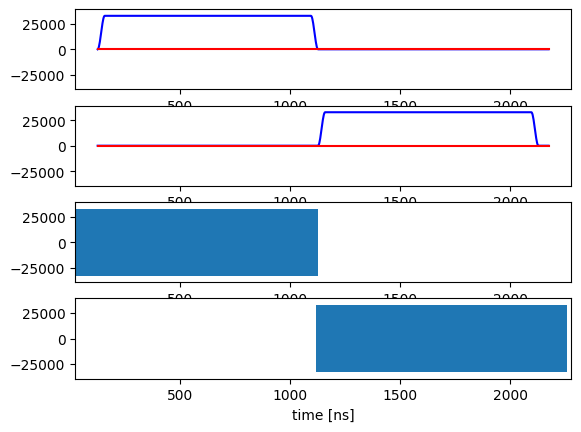

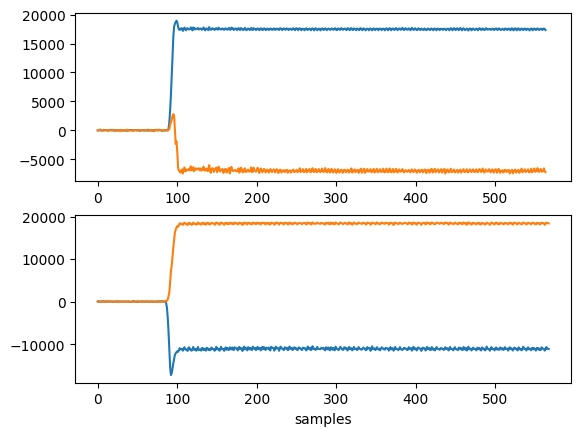

100%|██████████| 5/5 [00:00<00:00,  5.31it/s]


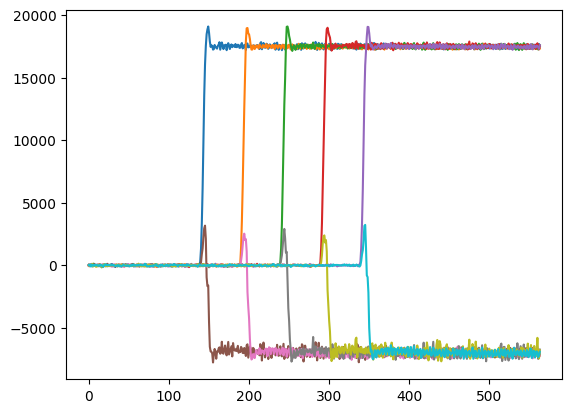

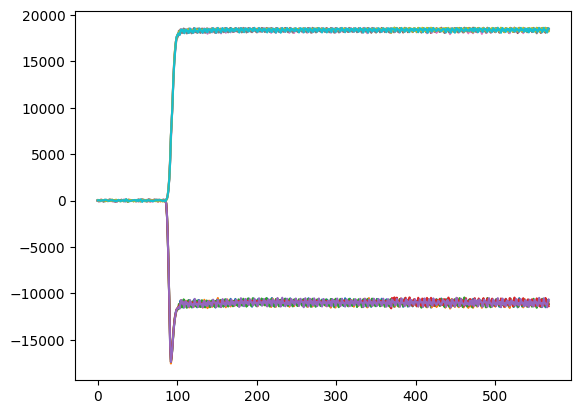

In [18]:
# =============================
# 共通部分
# =============================

%matplotlib inline
import matplotlib.pyplot as plt

from typing import Final

import e7awgsw
import qubecalib as qc
import qubecalib.neopulse as pulse
import qubecalib.backendqube as backend
from qubecalib.backendqube import ChannelMap
from qubecalib.neopulse import Sequence
from qubecalib.neopulse import RaisedCosFlatTop, Capture, Blank
from qubecalib.neopulse import Series, Flushleft, Flushright
from qubecalib.neopulse import Control, Readout
from qubecalib.units import *

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400
qube.port7.lo.mhz = 12000
qube.port7.nco.mhz = 2000
qube.port7.mix.vatt = 0x400
qube.port8.lo.mhz = 12000
qube.port8.nco.mhz = 2000
qube.port8.mix.vatt = 0x400
qube.port12.nco.mhz = 2000
qube.port13.lo.mhz = 8000
qube.port13.nco.mhz = 2000
qube.port13.mix.vatt = 0x400
qube.gpio.write_value(0xFFFF) # Loopback

# define Physical Port
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6
TXQ3: Final[qc.qube.Port] = qube.port7
TXQ4: Final[qc.qube.Port] = qube.port8
MUX2RX: Final[qc.qube.Port] = qube.port12
MUX2TX: Final[qc.qube.Port] = qube.port13

# define Logical Channel
RQ1: Final[Readout] = Readout(10000*MHz)
RQ2: Final[Readout] = Readout(10000*MHz)
CQ1: Final[Control] = Control(9990*MHz)
CQ2: Final[Control] = Control(10100*MHz)
CQ3: Final[Control] = Control(10100*MHz)
CQ4: Final[Control] = Control(9990*MHz)
RQ3: Final[Readout] = Readout(10000*MHz)
RQ4: Final[Readout] = Readout(10000*MHz)


with ChannelMap() as m:
    m.map(MUX1TX.awg0, RQ1, RQ2)
    m.map(MUX1RX.capt.unit0, RQ1)
    m.map(MUX1RX.capt.unit1, RQ2)
    m.map(TXQ1.awg0, CQ1)
    m.map(TXQ2.awg0, CQ2)
    m.map(TXQ3.awg0, CQ3)
    m.map(TXQ4.awg0, CQ4)
    m.map(MUX2RX.capt.unit0, RQ3)
    m.map(MUX2RX.capt.unit1, RQ4)
    m.map(MUX2TX.awg0, RQ3, RQ4)
channel_map = m

# =============================
# 共通部分：ここまで
# =============================

from traitlets import link

with Sequence() as sequence:

    rq1tx = RaisedCosFlatTop(duration=1000*nS, rise_time=32*nS).set_channel(RQ1)
    rq1rx = Capture(duration=1128*nS).set_channel(RQ1)
    rq4tx = RaisedCosFlatTop(duration=1000*nS, rise_time=32*nS).set_channel(RQ4)
    rq4rx = Capture(duration=1128*nS).set_channel(RQ4)
    link((rq1tx, 'end'), (rq1rx, 'end'))
    link((rq1rx, 'end'), (rq4rx, 'begin'))
    link((rq4tx, 'begin'), (rq4rx, 'begin'))
    
rq1rx.begin = 0

fig = plt.figure()
pulse.plot_sequence(fig, sequence.flatten())
plt.show()

section = backend.acquire_section(sequence, channel_map)

fig = plt.figure()
backend.plot_section(fig, section)
plt.show()

period = backend.quantize_sequence_duration(sequence_duration=400*uS)
setup = backend.convert(sequence.flatten(), section, channel_map, period, 1)

capture_delay = d = 7 * 16 # [words] int(7*2*WORDs)
for p, u, o in setup.captparams(channel_map):
    backend.captparam_add_capture_delay(p, d)
    # backend.captparam_enable_demodulation(p, u, o)
    # backend.captparam_enable_integration(p)

fig = plt.figure()
backend.plot_setup(fig,setup,capture_delay=d)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

r = backend.send_recv(*setup)

fig = plt.figure()
backend.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('samples')
plt.show()

from tqdm import tqdm
import numpy as np

rslt = {}
for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
    rslt[u] = []
for x in tqdm([900, 800, 700, 600, 500]):

    # Slot の再配置
    sequence.replace()
    rq1tx.duration = x * nS
    rq1rx.begin = 0

    # WaveSequence, CaptureParam への変換
    section = backend.acquire_section(sequence, channel_map)
    setup = backend.convert(sequence.flatten(), section, channel_map, period, 1)

    # CaptureParam の設定
    capture_delay = d = 7 * 16 # [words] int(7*2*WORDs)
    for p, u, o in setup.captparams(channel_map):
        backend.captparam_add_capture_delay(p, d)
        # backend.captparam_enable_demodulation(p, u, o)
        # backend.captparam_enable_integration(p)

    r = backend.send_recv(*setup)

    # データの格納
    for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
        rslt[u].append(r[u][0][:,0])

# グラフの描画
for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
    a = np.array(rslt[u]).transpose()
    plt.plot(np.real(a))
    plt.plot(np.imag(a))
    plt.show()


## レイアウト

エッジリンクをそれぞれの `Slot` に対して実施するのは煩雑なので，`Series`, `Flushleft`, `Flushright` のレイアウトクラスを用意しています．`Series` はコードプロック内で生成した `Slot` を数珠繋ぎにリンクします．この際，最初に生成した `Slot` あるいはレイアウトクラスの `begin` が最も左側の時間に，最後に生成した `Slot` あるいはレイアウトクラスの `end` が最も右側の時間になると仮定して，`series.begin` と `series.end` がリンクされます．`Flushleft` は左づめ，`Flushright` は右づめになっています．

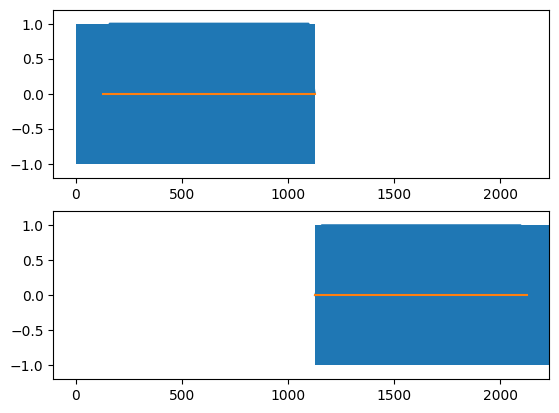

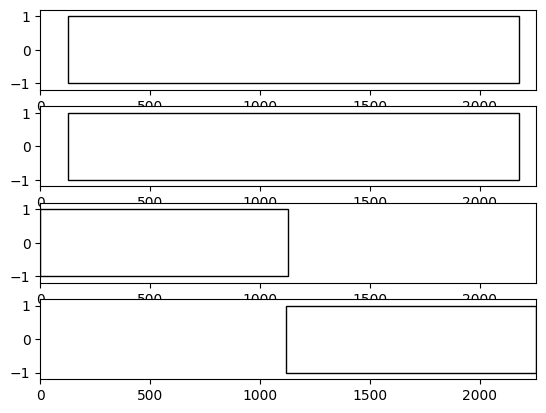

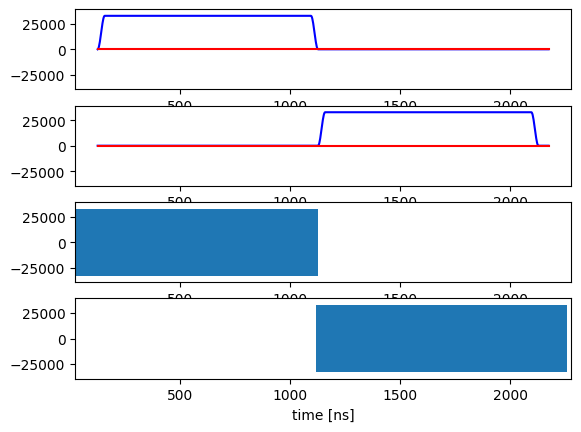

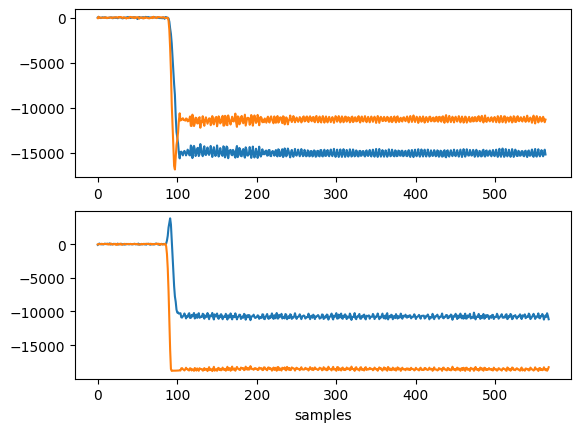

100%|██████████| 5/5 [00:00<00:00,  5.45it/s]


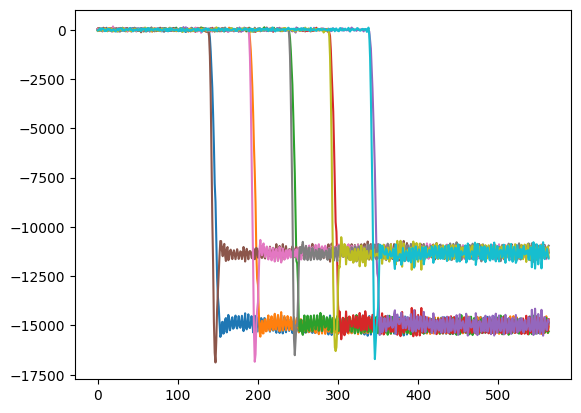

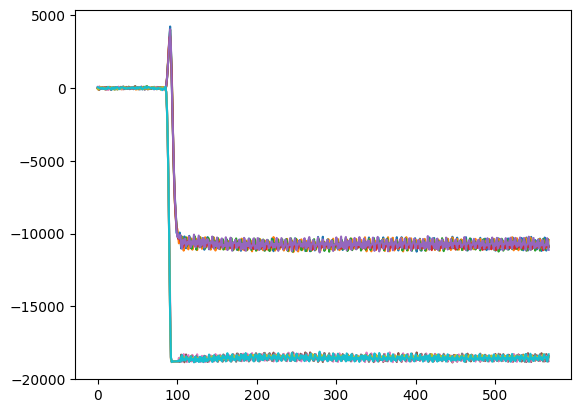

In [11]:
# =============================
# 共通部分
# =============================

%matplotlib inline
import matplotlib.pyplot as plt

from typing import Final

import e7awgsw
import qubecalib as qc
import qubecalib.neopulse as pulse
import qubecalib.backendqube as backend
from qubecalib.backendqube import ChannelMap
from qubecalib.neopulse import Sequence
from qubecalib.neopulse import RaisedCosFlatTop, Capture, Blank
from qubecalib.neopulse import Series, Flushleft, Flushright
from qubecalib.neopulse import Control, Readout
from qubecalib.units import *

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400
qube.port7.lo.mhz = 12000
qube.port7.nco.mhz = 2000
qube.port7.mix.vatt = 0x400
qube.port8.lo.mhz = 12000
qube.port8.nco.mhz = 2000
qube.port8.mix.vatt = 0x400
qube.port12.nco.mhz = 2000
qube.port13.lo.mhz = 8000
qube.port13.nco.mhz = 2000
qube.port13.mix.vatt = 0x400
qube.gpio.write_value(0xFFFF) # Loopback

# define Physical Port
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6
TXQ3: Final[qc.qube.Port] = qube.port7
TXQ4: Final[qc.qube.Port] = qube.port8
MUX2RX: Final[qc.qube.Port] = qube.port12
MUX2TX: Final[qc.qube.Port] = qube.port13

# define Logical Channel
RQ1: Final[Readout] = Readout(10000*MHz)
RQ2: Final[Readout] = Readout(10000*MHz)
CQ1: Final[Control] = Control(9990*MHz)
CQ2: Final[Control] = Control(10100*MHz)
CQ3: Final[Control] = Control(10100*MHz)
CQ4: Final[Control] = Control(9990*MHz)
RQ3: Final[Readout] = Readout(10000*MHz)
RQ4: Final[Readout] = Readout(10000*MHz)


with ChannelMap() as m:
    m.map(MUX1TX.awg0, RQ1, RQ2)
    m.map(MUX1RX.capt.unit0, RQ1)
    m.map(MUX1RX.capt.unit1, RQ2)
    m.map(TXQ1.awg0, CQ1)
    m.map(TXQ2.awg0, CQ2)
    m.map(TXQ3.awg0, CQ3)
    m.map(TXQ4.awg0, CQ4)
    m.map(MUX2RX.capt.unit0, RQ3)
    m.map(MUX2RX.capt.unit1, RQ4)
    m.map(MUX2TX.awg0, RQ3, RQ4)
channel_map = m

# =============================
# 共通部分：ここまで
# =============================

from traitlets import link

with Sequence() as sequence:

    with Series():
        with Flushright():
            rq1rx = Capture(duration=1128*nS).set_channel(RQ1)
            rq1tx = RaisedCosFlatTop(duration=1000*nS, rise_time=32*nS).set_channel(RQ1)
        with Flushleft():
            rq4tx = RaisedCosFlatTop(duration=1000*nS, rise_time=32*nS).set_channel(RQ4)
            rq4rx = Capture(duration=1128*nS).set_channel(RQ4)
    
rq1rx.begin = 0

fig = plt.figure()
pulse.plot_sequence(fig, sequence.flatten())
plt.show()

section = backend.acquire_section(sequence, channel_map)

fig = plt.figure()
backend.plot_section(fig, section)
plt.show()

period = backend.quantize_sequence_duration(sequence_duration=400*uS)
setup = backend.convert(sequence.flatten(), section, channel_map, period, 1)

capture_delay = d = 7 * 16 # [words] int(7*2*WORDs)
for p, u, o in setup.captparams(channel_map):
    backend.captparam_add_capture_delay(p, d)
    # backend.captparam_enable_demodulation(p, u, o)
    # backend.captparam_enable_integration(p)

fig = plt.figure()
backend.plot_setup(fig,setup,capture_delay=d)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

r = backend.send_recv(*setup)

fig = plt.figure()
backend.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('samples')
plt.show()

from tqdm import tqdm
import numpy as np

rslt = {}
for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
    rslt[u] = []
for x in tqdm([900, 800, 700, 600, 500]):

    # Slot の再配置
    sequence.replace()
    rq1tx.duration = x * nS
    rq1rx.begin = 0

    # WaveSequence, CaptureParam への変換
    section = backend.acquire_section(sequence, channel_map)
    setup = backend.convert(sequence.flatten(), section, channel_map, period, 1)

    # CaptureParam の設定
    capture_delay = d = 7 * 16 # [words] int(7*2*WORDs)
    for p, u, o in setup.captparams(channel_map):
        backend.captparam_add_capture_delay(p, d)
        # backend.captparam_enable_demodulation(p, u, o)
        # backend.captparam_enable_integration(p)

    r = backend.send_recv(*setup)

    # データの格納
    for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
        rslt[u].append(r[u][0][:,0])

# グラフの描画
for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
    a = np.array(rslt[u]).transpose()
    plt.plot(np.real(a))
    plt.plot(np.imag(a))
    plt.show()


## パルスの再利用

定型的なパルスシーケンスは再利用できるようライプラリ化するべきです．qube-calib では `with Sequence` のコードブロック内で `Slot` を生成すると `sequence` に追加される仕組みを利用してライブラリを作れます． 

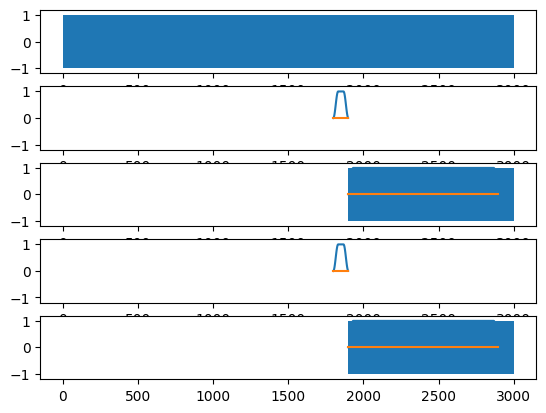

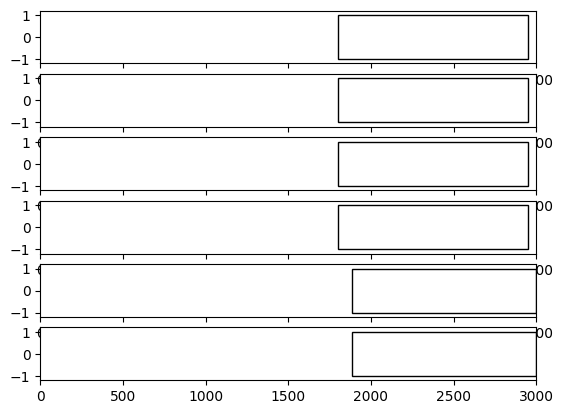

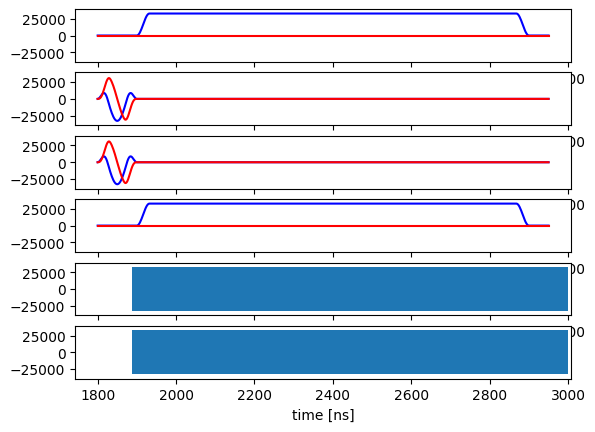

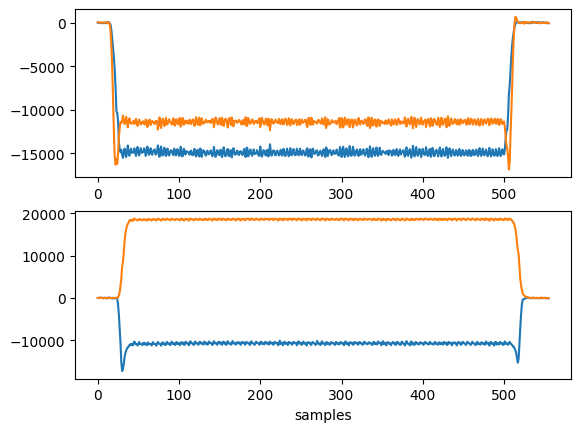

100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


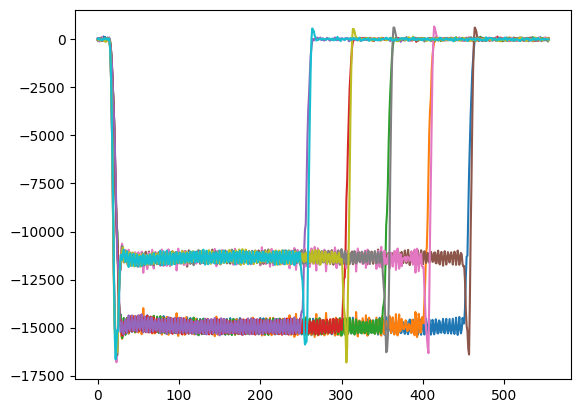

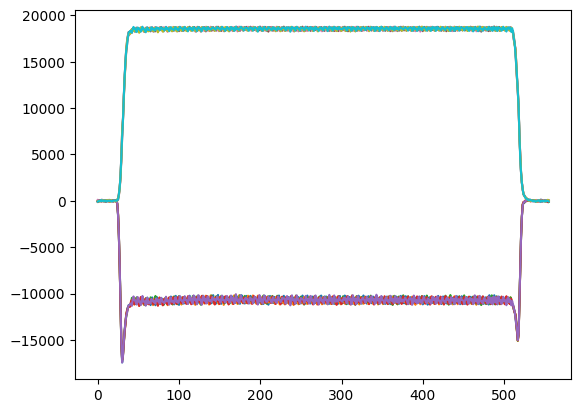

In [14]:
# =============================
# 共通部分
# =============================

%matplotlib inline
import matplotlib.pyplot as plt

from typing import Final

import e7awgsw
import qubecalib as qc
import qubecalib.neopulse as pulse
import qubecalib.backendqube as backend
from qubecalib.backendqube import ChannelMap
from qubecalib.neopulse import Sequence
from qubecalib.neopulse import RaisedCosFlatTop, Capture, Blank
from qubecalib.neopulse import Series, Flushleft, Flushright
from qubecalib.neopulse import Control, Readout
from qubecalib.units import *

qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400
qube.port1.nco.mhz = 2000
qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400
qube.port7.lo.mhz = 12000
qube.port7.nco.mhz = 2000
qube.port7.mix.vatt = 0x400
qube.port8.lo.mhz = 12000
qube.port8.nco.mhz = 2000
qube.port8.mix.vatt = 0x400
qube.port12.nco.mhz = 2000
qube.port13.lo.mhz = 8000
qube.port13.nco.mhz = 2000
qube.port13.mix.vatt = 0x400
qube.gpio.write_value(0xFFFF) # Loopback

# define Physical Port
MUX1TX: Final[qc.qube.Port] = qube.port0
MUX1RX: Final[qc.qube.Port] = qube.port1
TXQ1: Final[qc.qube.Port] = qube.port5
TXQ2: Final[qc.qube.Port] = qube.port6
TXQ3: Final[qc.qube.Port] = qube.port7
TXQ4: Final[qc.qube.Port] = qube.port8
MUX2RX: Final[qc.qube.Port] = qube.port12
MUX2TX: Final[qc.qube.Port] = qube.port13

# define Logical Channel
RQ1: Final[Readout] = Readout(10000*MHz)
RQ2: Final[Readout] = Readout(10000*MHz)
CQ1: Final[Control] = Control(9990*MHz)
CQ2: Final[Control] = Control(10100*MHz)
CQ3: Final[Control] = Control(10100*MHz)
CQ4: Final[Control] = Control(9990*MHz)
RQ3: Final[Readout] = Readout(10000*MHz)
RQ4: Final[Readout] = Readout(10000*MHz)

with ChannelMap() as m:
    m.map(MUX1TX.awg0, RQ1, RQ2)
    m.map(MUX1RX.capt.unit0, RQ1)
    m.map(MUX1RX.capt.unit1, RQ2)
    m.map(TXQ1.awg0, CQ1)
    m.map(TXQ2.awg0, CQ2)
    m.map(TXQ3.awg0, CQ3)
    m.map(TXQ4.awg0, CQ4)
    m.map(MUX2RX.capt.unit0, RQ3)
    m.map(MUX2RX.capt.unit1, RQ4)
    m.map(MUX2TX.awg0, RQ3, RQ4)
channel_map = m

# =============================
# 共通部分：ここまで
# =============================

from traitlets import link

class RabiSequence( object ):

    def __init__(self, control_channel, readout_channel):

        with Series():
            self.control = RaisedCosFlatTop().set_channel(control_channel)
            with Flushleft():
                self.readout = RaisedCosFlatTop().set_channel(readout_channel)
                self.capture = Capture().set_channel(readout_channel)

with Sequence() as sequence:

    with Flushright():

        offset = Blank()
        rabiq1 = RabiSequence(CQ1, RQ1)
        rabiq2 = RabiSequence(CQ4, RQ4)

offset.duration = 3000*nS
rabiq1.control.rise_time = 32*nS
rabiq1.control.duration = 100*nS
rabiq1.readout.rise_time = 32*nS
rabiq1.readout.duration = 1000*nS
rabiq1.capture.duration = 1100*nS
rabiq2.control.rise_time = 32*nS
rabiq2.control.duration = 100*nS
rabiq2.readout.rise_time = 32*nS
rabiq2.readout.duration = 1000*nS
rabiq2.capture.duration = 1100*nS

offset.begin = 0

fig = plt.figure()
pulse.plot_sequence(fig, sequence.flatten())
plt.show()

section = backend.acquire_section(sequence, channel_map)

fig = plt.figure()
backend.plot_section(fig, section)
plt.show()

period = backend.quantize_sequence_duration(sequence_duration=400*uS)
setup = backend.convert(sequence.flatten(), section, channel_map, period, 1)

capture_delay = d = 8 * 16 # [words] int(7*2*WORDs)
for p, u, o in setup.captparams(channel_map):
    backend.captparam_add_capture_delay(p, d)
    # backend.captparam_enable_demodulation(p, u, o)
    # backend.captparam_enable_integration(p)

fig = plt.figure()
backend.plot_setup(fig,setup,capture_delay=d)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

r = backend.send_recv(*setup)

fig = plt.figure()
backend.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('samples')
plt.show()

from tqdm import tqdm
import numpy as np

rslt = {}
for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
    rslt[u] = []
for x in tqdm([900, 800, 700, 600, 500]):

    # Slot の再配置
    sequence.replace()
    rabiq1.control.duration = x * nS
    rabiq1.readout.duration = x * nS
    offset.begin = 0

    # WaveSequence, CaptureParam への変換
    section = backend.acquire_section(sequence, channel_map)
    setup = backend.convert(sequence.flatten(), section, channel_map, period, 1)

    # CaptureParam の設定
    capture_delay = d = 8 * 16 # [words] int(7*2*WORDs)
    for p, u, o in setup.captparams(channel_map):
        backend.captparam_add_capture_delay(p, d)
        # backend.captparam_enable_demodulation(p, u, o)
        # backend.captparam_enable_integration(p)

    r = backend.send_recv(*setup)

    # データの格納
    for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
        rslt[u].append(r[u][0][:,0])

# グラフの描画
for u in [u for o in [RQ1, RQ4] for u in channel_map.physical[o] if isinstance(u, qc.qube.UNIT)]:
    a = np.array(rslt[u]).transpose()
    plt.plot(np.real(a))
    plt.plot(np.imag(a))
    plt.show()


# [Experimental] WaveChunk の repeats を活用してみる

下記のようなポストセレクションなどのとても長いシーケンスを実施する際に WaveChunk の活用が大変便利であるため，活用する方法を考えている．

```
[ chunk0 ][ chunk0 ]...[chunk0][chunk1]
```

次のパターンのシーケンス（`Series`が２段の入れ子になっていて`Blank`で間隔調整している構造）で２段目の各 `Series` がそれぞれの `WaveChunk` に対応しています．`CaptureParam` の `SumSection` は繰り返しに対応していないので 4096 個を別個登録しています．

```
with Sequence():
    with Series():
        with Series(repeats=/^[0-9]+$/)
            <pulse sequence blocks ...>
        Blank() # なくてもいい
        with Series(repeats=/^[0-9]+$/)
            <pulse sequence blocks ...>
```


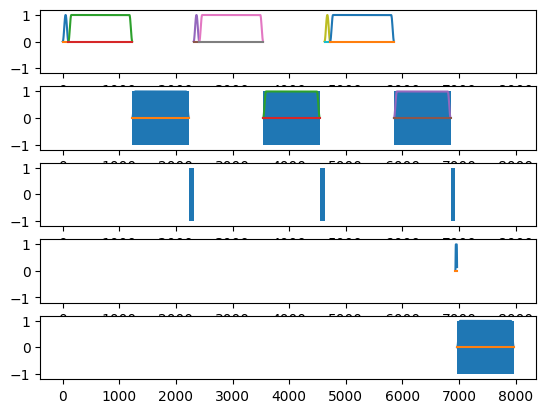

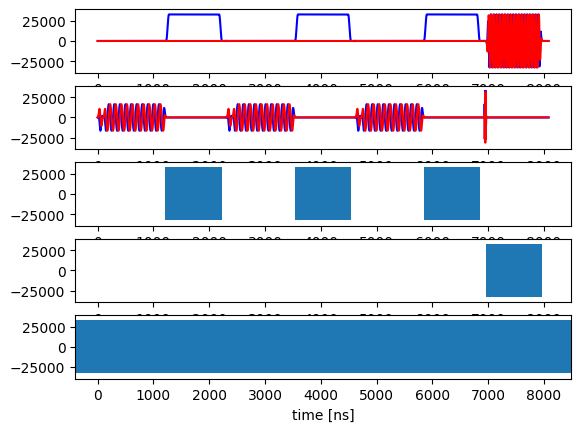

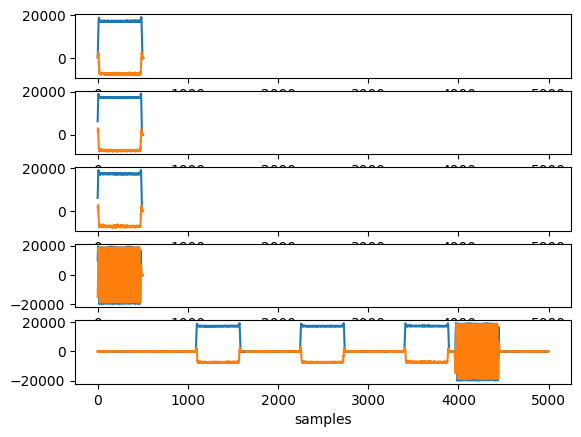

[<qubecalib.qube.UNIT object at 0x7f414e80bdc0>, <qubecalib.qube.UNIT object at 0x7f414e80bdc0>, <qubecalib.qube.UNIT object at 0x7f414e80bdc0>, <qubecalib.qube.UNIT object at 0x7f414e80ba30>, <qubecalib.qube.UNIT object at 0x7f414e80beb0>]


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

from typing import Final

import e7awgsw
import qubecalib as qc
import qubecalib.neopulse as pulse
import qubecalib.neopulse as pulse
import qubecalib.backendqube as backend
from qubecalib.backendqube import ChannelMap
from qubecalib.neopulse import Sequence, Series, Flushleft, Flushright
from qubecalib.neopulse import RaisedCosFlatTop, Capture, Blank
from qubecalib.neopulse import Control, Readout
from qubecalib.units import *

# Qube 装置のアナログ設定
# このあたりは将来的に quel 製のサーバー類にお任せする予定
# qube = qc.qube.Qube.create('qube_riken_1-01.yml')
qube = qc.qube.Qube.create('qube_riken_1-02.yml')
qube.port0.lo.mhz = 8000 # 12500
qube.port0.nco.mhz = 2000
qube.port0.mix.vatt = 0x400 # 0x800
qube.port1.nco.mhz = 2000

qube.port5.lo.mhz = 12000
qube.port5.nco.mhz = 2000
qube.port5.mix.vatt = 0x400 # 0xA00
qube.port6.lo.mhz = 12000
qube.port6.nco.mhz = 2000
qube.port6.mix.vatt = 0x400 # 0xA00

qube.gpio.write_value(0xFFFF) # Loopback

# define Physical Port
MUX1TX: Final[qc.qube.Port] = qube.port0 # qube.port13
MUX1RX: Final[qc.qube.Port] = qube.port1 # qube.port12
TXQ1: Final[qc.qube.Port] = qube.port5 # qube.port8
TXQ2: Final[qc.qube.Port] = qube.port6 # qube.port7

# define Logical Channel
CQ1: Final[Control] = Control(9990*MHz)
RQ1: Final[Readout] = Readout(10000*MHz)
CQ2: Final[Control] = Control(10100*MHz)
RQ2: Final[Readout] = Readout(10020*MHz)
RQ3: Final[Readout] = Readout(10000*MHz)

# 物理チャネルと論理チャネルの対応マップ
# 第一引数が物理チャネル
# 第二引数以下が論理チャネルで複数取れる
# 物理チャネルを重複して定義してはいけない
with ChannelMap() as m:
    m.map(MUX1TX.awg0, RQ1, RQ2)
    m.map(MUX1RX.capt.unit0, RQ1)
    m.map(MUX1RX.capt.unit1, RQ2)
    # m.map(MUX1RX.capt.unit2, RQ3)
    m.map(TXQ1.awg0, CQ1, CQ2)
channel_map = m

# 波形形状と位置を示す Slot を配置した Sequence の定義
# 実験コードでは主にここを修正する
with Sequence() as sequence:
    with Series():
        with Series(repeats=3) as sq0: # Sq0
            sq0_ctrl0 = RaisedCosFlatTop(duration=100*nS).set_channel(CQ1)
            sq0_ctrl0.rise_time = 50*nS
            sq0_ctrl1 = RaisedCosFlatTop(duration=1128*nS).set_channel(CQ1)
            sq0_ctrl1.rise_time = 50*nS
            with Flushleft():
                sq0_read = RaisedCosFlatTop(duration=1000*nS).set_channel(RQ1)
                sq0_read.rise_time = 50*nS
                sq0_capt = Capture(duration=1000*nS).set_channel(RQ1)
            Blank(duration=84*nS)
        Blank(duration=0*nS)
        with Series(repeats=1) as sq1: # Sq1
            sq1_ctrl = RaisedCosFlatTop(duration=32*nS).set_channel(CQ2)
            sq1_ctrl.rise_time = 8*nS
            with Flushleft():
                sq1_read = RaisedCosFlatTop(duration=1000*nS).set_channel(RQ2)
                sq1_read.rise_time = 50*nS
                sq1_capt = Capture(duration=1000*nS).set_channel(RQ2)

sequence[0].begin = 0

# sequence の内容を表示する
# Logical Channel 毎に縦に並んでいる
# 最も下の段は Blank など channel が割り当てられていない Slot
fig = plt.figure()
pulse.plot_sequence(fig, sequence.flatten())
plt.show()

section = backend.acquire_section(sequence, channel_map) #, section)

period = backend.quantize_sequence_duration(sequence_duration=400*uS)
setup = backend.convert(sequence=sequence.flatten(), section=section, channel_map=channel_map, period=period, repeats=1)

# 全体波形観測用の CaptureParam を追加
p = e7awgsw.CaptureParam()
p.num_integ_sections = 1
p.capture_delay = 0
duration = 10000
blank = period - duration
p.add_sum_section(num_words=int(duration) // int(WORD), num_post_blank_words=int(blank) // int(WORD))
setup.append((MUX1RX.capt.unit2, p))

# 生成した WaveSequence と CaptureParam を調整する
capture_delay = d = 8 * 16 # [words] int(7*2*WORDs)
for p, u, o in setup.captparams(channel_map):
    backend.captparam_add_capture_delay(p, d)
    # backend.captparam_enable_demodulation(p, u, o)
    backend.captparam_enable_integration(p)

# setup の内容を図示する
fig = plt.figure()
backend.plot_setup(fig,setup,capture_delay=d)
fig.axes[-1].set_xlabel('time [ns]')
plt.show()

# 実際に qube から信号の送受信をする
r = backend.send_recv(*setup)

# 測定結果を表示する
# 上からキャプチャタイミングが若い順に表示
fig = plt.figure()
u = backend.plot_send_recv(fig,r)
fig.axes[-1].set_xlabel('samples')
plt.show()
print([k for k in u])